# **Different Types of Recommendations**
(This is subject to change because I don't know everything about the website)


```
- Podcasts
- Learning Bundles and Plans
- News and Webinars
- Top Content (Maybe add a note that its popular)
```



In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab import files

# **Generate Fake Data**

In [ ]:
import pandas as pd
from random import randint

This function will generate a dataset with the associated features


```
user_ID (String): String to identify the user
podcast_ID (Integer): 
bundle_ID (Integer): 
news_ID (Integer): 
webinar_ID (Integer): 
topContent_ID (Integer):
```


```
# Parameters

n_user (Integer): 
n_podcast (Integer): 
n_bundle (Integer): 
n_news (Integer): 
n_webinar (Integer): 
n_topContent (Integer):
```


```
# Invocation

data = dataGenerator()
```





**Tracking Visitor Information (Analytics) for an ASP.NET Web Pages (Razor) Site**
[LINK](https://docs.microsoft.com/en-us/aspnet/web-pages/overview/performance-and-traffic/14-analyzing-traffic)

In [ ]:
def dataGenerator(n_user = 3000, n_podcast = 100, n_bundle = 500, n_news = 500, n_webinar = 500, n_topContent = 25, dataset_size = 10000, max_time = 1000):


    generator = pd.DataFrame(
        {
            # Populate with random values          
            'top_podcast_ID' : [randint(1, n_podcast) for _ in range(dataset_size)], 
            'podcast_ID_TIME' : [randint(1, max_time) for _ in range(dataset_size)],
         
            'top_bundle_ID' : [randint(1, n_bundle) for _ in range(dataset_size)],
            'bundle_ID_TIME' : [randint(1, max_time) for _ in range(dataset_size)],
         
            'top_news_ID' : [randint(1, n_news) for _ in range(dataset_size)],
            'news_ID_TIME' : [randint(1, max_time) for _ in range(dataset_size)],
         
            'top_webinar_ID' : [randint(1, n_news) for _ in range(dataset_size)],
            'webinar_ID_TIME' : [randint(1, max_time) for _ in range(dataset_size)],
         
      
        }
    ).drop_duplicates()
    return generator

generator = dataGenerator(dataset_size = 100000)
generator.to_csv('fakeData.csv', index = False)
generator.head()
    
  


,top_podcast_ID,podcast_ID_TIME,top_bundle_ID,bundle_ID_TIME,top_news_ID,news_ID_TIME,top_webinar_ID,webinar_ID_TIME
0,72,314,25,486,191,77,452,714
1,2,537,86,524,43,630,356,125
2,54,703,33,920,55,3,466,196
3,3,956,32,616,185,45,159,24
4,48,35,428,825,135,395,97,657


# **Test Data**



```
# File is formatted with each user having mutiple product ID's. They also have a corresponding timestamp. 

User ID's: 610 
Product ID's: Between 1 - 3000
Timestamp: 1- 10,000
```



In [ ]:
x = files.upload()

Saving reccomendations.csv to reccomendations.csv


```
# File is formatted with each user having mutiple product ID's. They also have a corresponding timestamp. 

User ID's: 610 
Product ID's: Between 1 - 3000
Timestamp: 1- 10,000
```

In [ ]:
df = pd.read_csv('reccomendations.csv' , delimiter = ',')
df.head()

,userID,productID,timestamp
0,1,2217,3398
1,1,952,9846
2,1,1082,209
3,1,1847,7825
4,1,786,5726


# **Preprocess the Data**

In [ ]:
user_IDs = df["userID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_IDs)}
userencoded2user = {i: x for i, x in enumerate(user_IDs)}


product_IDs = df["productID"].unique().tolist()
product2product_encoded = {x: i for i, x in enumerate(product_IDs)}
product_encoded2product = {i: x for i, x in enumerate(product_IDs)}


df["user"] = df["userID"].map(user2user_encoded)
df["product"] = df["productID"].map(product2product_encoded)

num_users = len(user2user_encoded)
num_product = len(product_encoded2product)

df["timestamp"] = df["timestamp"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["timestamp"])
max_rating = max(df["timestamp"])

print(
    "Number of users: {}, Number of Movies: {}, Min timestamp: {}, Max timestamp: {}".format(
        num_users, num_product, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 3000, Min timestamp: 1.0, Max timestamp: 10000.0


# **Create Training and Validation Data**

In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "product"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["timestamp"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# **Create Model**

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_product, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_product = num_product
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_product,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_product, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_product, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 10s 6ms/step - loss: 0.6953 - val_loss: 0.6979
Epoch 2/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6985 - val_loss: 0.6997
Epoch 3/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.7004 - val_loss: 0.7027
Epoch 4/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.7026 - val_loss: 0.7035
Epoch 5/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.7047 - val_loss: 0.7051


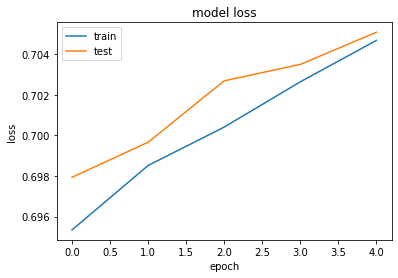

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [ ]:
p = files.upload()

Saving productNames.csv to productNames.csv


In [ ]:
productNames = pd.read_csv("productNames.csv", delimiter = ',')
print(productNames.head())

   productID productName
0       2217        News
1        952        News
2       1082        News
3       1847      Bundle
4        786     Webinar


In [ ]:
movie_df = pd.read_csv('productNames.csv' , delimiter = ',')
# Let us get a user and see the top recommendations.
user_ID = df.userID.sample(1).iloc[0]
movies_watched_by_user = df[df.userID == user_ID]
movies_not_watched = movie_df[
    ~movie_df["productID"].isin(movies_watched_by_user.productID.values)
]["productID"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(product2product_encoded.keys()))
)
movies_not_watched = [[product2product_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_ID)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    product_encoded2product.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_ID))
print("====" * 9)
print("Products with high timestamps from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="timestamp", ascending=False)
    .head(5)
    .productID.values
)
movie_df_rows = movie_df[movie_df["productID"].isin(top_movies_user)]
for row in movie_df_rows.itertuples(): 
    print(row.productID)
    #print("hi")

print("----" * 8)
print("Top product recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["productID"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.productID)
    #print("hi")


Showing recommendations for user: 606
Products with high timestamps from user
--------------------------------
2236
710
2236
2236
2236
710
285
1222
710
1222
2236
710
325
2236
2236
1222
710
710
710
325
325
285
285
2236
325
710
325
2236
325
2236
710
710
325
325
1222
2236
325
1222
710
285
1222
2236
1222
1222
1222
285
325
710
1222
1222
285
1222
2236
1222
325
1222
710
1222
285
710
2236
1222
2236
2236
2236
325
325
2236
325
285
2236
2236
710
2236
2236
325
325
2236
285
1222
1222
2236
2236
285
285
710
2236
325
2236
1222
710
1222
710
2236
1222
325
325
325
1222
2236
2236
285
325
710
2236
285
710
1222
1222
285
2236
325
2236
2236
285
285
285
2236
710
710
1222
325
710
285
710
325
710
325
1222
1222
325
710
1222
2236
710
285
1222
325
2236
325
1222
325
1222
285
325
285
1222
325
1222
1222
710
2236
1222
2236
325
1222
2236
710
2236
1222
2236
1222
285
1222
325
1222
325
710
2236
2236
1222
710
325
285
285
325
1222
2236
2236
285
--------------------------------
Top product recommendations
--------------------

In [ ]:
# remove duplicated from list 
result = [] 
for i in sam_list: 
    if i not in result: 
        result.append(i) 

# printing list after removal 
print ("The list after removing duplicates : " + str(result)) 

# **Content Based System**

Create recommendations based off on the users preferences. Try and match users to perferences that they've clicked on or done before. 

NOTE: This system will not leverage ratings between other users. 

MAYBE: To generate recommended content when the user has not clicked on anything it might be best to recommned content based on score performance. That could be a lot of work and out of the scope of the data that is taken. It might just be easier to recommend based off of popular content. 

In [ ]:
data = dataGenerator('podcastData.csv')

In [ ]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm 

In [ ]:
def normalize(data):
    '''
    This function will normalize the input data to be between 0 and 1
    
    params:
        data (List) : The list of values you want to normalize
    
    returns:
        The input data normalized between 0 and 1
    '''
    min_val = min(data)
    if min_val < 0:
        data = [x + abs(min_val) for x in data]
    max_val = max(data)
    return [x/max_val for x in data]

In [ ]:
class CBRecommend():
    def __init__(self, df):
        self.df = df
        
    def cosine_sim(self, v1,v2):
        '''
        This function will calculate the cosine similarity between two vectors
        '''
        return sum(dot(v1,v2)/(norm(v1)*norm(v2)))
    
    def recommend(self, book_id, n_rec):
        """
        df (dataframe): The dataframe
        song_id (string): Representing the song name
        n_rec (int): amount of rec user wants
        """
        
        # calculate similarity of input book_id vector w.r.t all other vectors
        inputVec = self.df.loc[book_id].values
        self.df['sim']= self.df.apply(lambda x: self.cosine_sim(inputVec, x.values), axis=1)

        # returns top n user specified books
        return self.df.nlargest(columns='sim',n=n_rec)

if __name__ == '__main__':
    # import data
    df = pd.read_csv('fakeData.csv')

    # normalize the num_pages, ratings, price columns
    df['podcast_ID_TIME_norm'] = normalize(df['podcast_ID_TIME'].values)
    df['bundle_ID_TIME_norm'] = normalize(df['bundle_ID_TIME'].values)
    df['news_ID_TIME_norm'] = normalize(df['news_ID_TIME'].values)
    df['webinar_ID_TIME_norm'] = normalize(df['webinar_ID_TIME'].values)

    # ran on a sample as an example
    t = df.copy()
    cbr = CBRecommend(df = t)
    print(cbr.recommend(book_id = t.index[0], n_rec = 5))

TypeError: ignored